In [1]:
import glob
import os

from collections import defaultdict
from itertools import count

import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import toposort

In [2]:
alternates = {'gtk2hs-buildtools', 'c2hs', 'cpphs', 'pandoc'}

In [3]:
def read_spec(fn):
    package_deps = set()
    with open(fn, 'r') as f:
        ignore_lines = False
        for line in f:
            line = line.split('#', maxsplit=1)[0].strip()
            if line == '%if %{with tests}':
                ignore_lines = True
            elif ignore_lines:
                if line == '%endif':
                    ignore_lines = False
            elif 'BuildRequires' in line:
                dep = line.split(':')[1].split()[0]
                if dep.endswith('-devel'):
                    dep = dep[:-6]
                if dep in ('ghc-Cabal', 'ghc-rpm-macros'):
                    continue
                if not (dep.startswith('ghc-') or dep in alternates):
                    continue

                package_deps.add(dep)

    return os.path.basename(fn).split('.')[0], package_deps

In [4]:
def find_package_type(name):
    dirs = name.split(os.sep)
    if len(dirs) == 3:
        return dirs[0]
    else:
        return 'Top-level'

In [5]:
G = nx.DiGraph()

In [6]:
our_packages = set()
pkg_by_type = defaultdict(set)

for fn in glob.iglob('**/*.spec', recursive=True):
    package_name, package_deps = read_spec(fn)
    package_type = find_package_type(fn)
    pkg_by_type[package_type].add(package_name)
    our_packages.add(package_name)
    G.add_node(package_name, package_type=package_type)
    for dep_name in package_deps:
        G.add_edge(package_name, dep_name)

In [7]:
# Special case (produced from same package.)
G = nx.relabel_nodes(G,
                     {'ghc-cpphs': 'cpphs',
                      'ghc-c2hs': 'c2hs',
                      'ghc-pandoc': 'pandoc'})

In [8]:
[k for k, v in G.in_degree().items() if v == 0]

['git-annex']

In [9]:
updated = """
ghc-adjunctions
ghc-aeson-compat
ghc-asn1-encoding
ghc-asn1-parse
ghc-asn1-types
ghc-attoparsec-iso8601
ghc-aws
ghc-base-orphans
ghc-bencode
ghc-bifunctors
ghc-cipher-aes
ghc-clientsession
ghc-comonad
ghc-concurrent-output
ghc-connection
ghc-cprng-aes
ghc-cryptohash-conduit
ghc-cryptonite
ghc-crypto-random
ghc-DAV
ghc-disk-free-space
ghc-dns
ghc-email-validate
ghc-esqueleto
ghc-fdo-notify
ghc-feed
ghc-file-embed
ghc-foundation
ghc-free
ghc-generic-deriving
ghc-hourglass
ghc-http-api-data
ghc-http-client
ghc-http-client-tls
ghc-http-conduit
ghc-kan-extensions
ghc-lens
ghc-magic
ghc-memory
ghc-microlens
ghc-microlens-th
ghc-mountpoints
ghc-network-info
ghc-network-multicast
ghc-pem
ghc-persistent
ghc-persistent-sqlite
ghc-persistent-template
ghc-profunctors
ghc-resource-pool
ghc-sandi
ghc-semigroupoids
ghc-silently
ghc-skein
ghc-socks
ghc-terminal-size
ghc-th-abstraction
ghc-tls
ghc-tls-session-manager
ghc-torrent
ghc-uri-bytestring
ghc-wai-app-static
ghc-warp-tls
ghc-x509
ghc-x509-store
ghc-x509-system
ghc-x509-validation
ghc-xml-hamlet
ghc-yesod
ghc-yesod-core
ghc-yesod-default
ghc-yesod-form
ghc-yesod-persistent
ghc-yesod-static
git-annex
""".split()

In [10]:
updated_pkgs = []
for pkg in updated:
    required = nx.ancestors(G, pkg)
    required.add(pkg)

    G2 = G.subgraph(required)
    updated_pkgs.append(G2)

updated_pkgs = nx.compose_all(updated_pkgs)

In [11]:
# Networkx's topological sort does not providing grouping by the level,
# so use the toposort package instead.
updated_pkg_set = {k: set(v) for k, v in nx.to_dict_of_lists(updated_pkgs).items()}
updated_pkg_set = list(toposort.toposort(updated_pkg_set))
for i, builds in zip(count(), updated_pkg_set):
    print(i, len(builds), end=' ')
    print(*sorted(builds))

0 32 ghc-attoparsec-iso8601 ghc-base-orphans ghc-bencode ghc-cipher-aes ghc-comonad ghc-crypto-random ghc-cryptohash-conduit ghc-disk-free-space ghc-dns ghc-email-validate ghc-fdo-notify ghc-feed ghc-file-embed ghc-foundation ghc-generic-deriving ghc-hourglass ghc-http-client ghc-magic ghc-microlens ghc-mountpoints ghc-network-info ghc-network-multicast ghc-pem ghc-resource-pool ghc-sandi ghc-silently ghc-skein ghc-socks ghc-terminal-size ghc-th-abstraction ghc-uri-bytestring ghc-xml-hamlet
1 8 ghc-aeson-compat ghc-bifunctors ghc-concurrent-output ghc-cprng-aes ghc-http-api-data ghc-memory ghc-microlens-th ghc-torrent
2 6 ghc-asn1-types ghc-clientsession ghc-cryptonite ghc-persistent ghc-profunctors ghc-semigroupoids
3 7 ghc-asn1-encoding ghc-esqueleto ghc-free ghc-persistent-sqlite ghc-persistent-template ghc-wai-app-static ghc-yesod-core
4 5 ghc-adjunctions ghc-asn1-parse ghc-yesod-default ghc-yesod-persistent ghc-yesod-static
5 3 ghc-kan-extensions ghc-x509 ghc-yesod-form
6 3 ghc-le

<IPython.core.display.Javascript object>


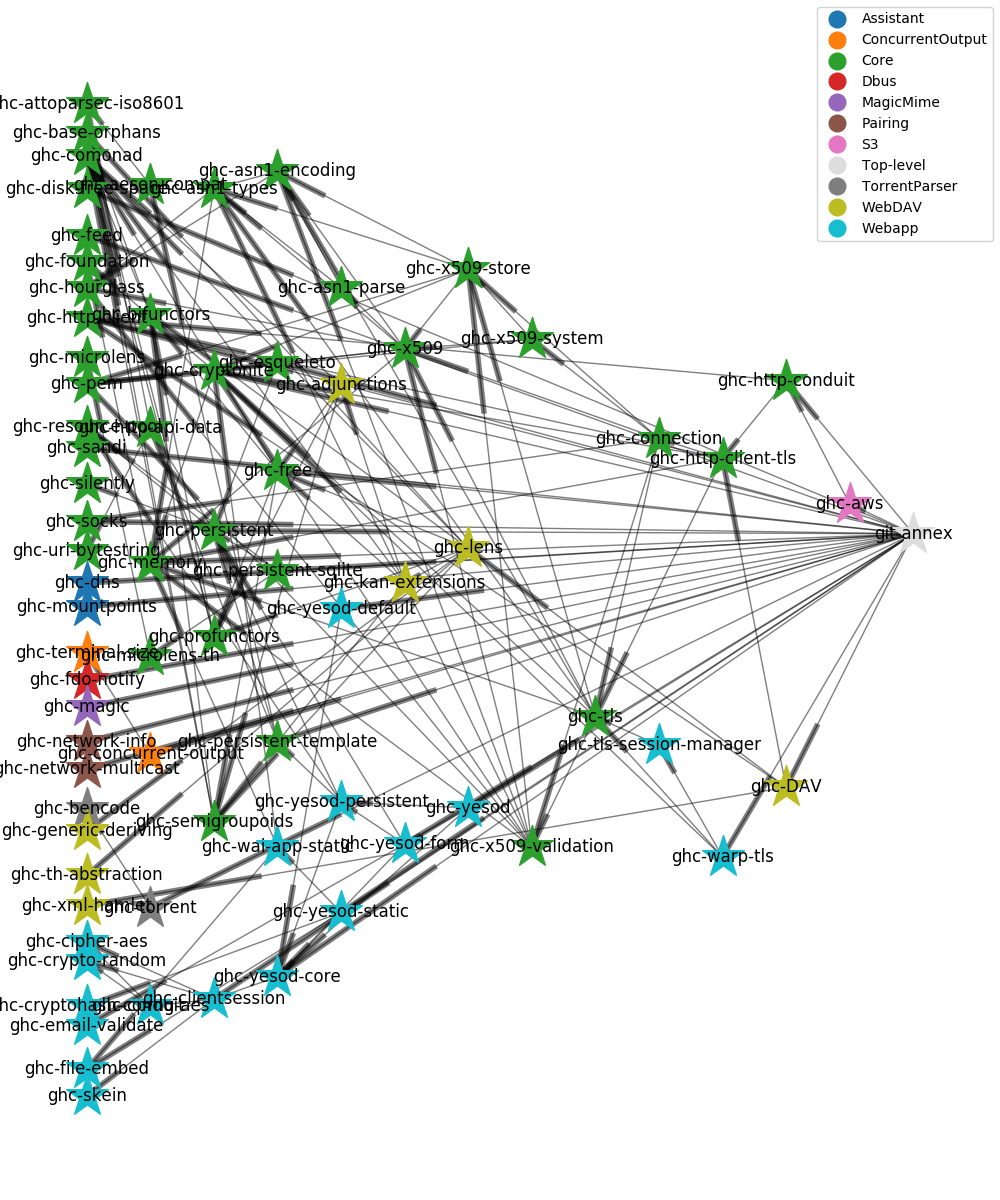

In [12]:
def pkg_key(name):
    if name in pkg_by_type['Top-level']:
        return (0, name)
    elif name in pkg_by_type['Core']:
        return (1, name)
    else:
        pkg_types = sorted(pkg_by_type)
        pkg_types.remove('Top-level')
        pkg_types.remove('Core')
        for i, pkg_type in enumerate(pkg_types, start=2):
            if name in pkg_by_type[pkg_type]:
                return (i, name)
        
    return (123, name)

fig = plt.figure(figsize=(10, 12), facecolor='w')
ax = plt.axes([0, 0, 1, 1])
ax.axis('off')

# pos = nx.spring_layout(updated_pkgs)
pos = {}
for layer, pkg_set in enumerate(updated_pkg_set):
    x = layer / len(updated_pkg_set) * 0.9
    for i, pkg in enumerate(sorted(pkg_set, key=pkg_key)):
        y = 1 - (i + 1) / (len(pkg_set) + 1) + (np.random.random() - 0.5) / (len(pkg_set) + 1) * 0.5
        pos[pkg] = (x, y)

explicitly_updated_set = set(updated)
toplevel = sorted(pkg_by_type).index('Top-level')
markers = []
for i, (pkg_type, pkg_set) in enumerate(sorted(pkg_by_type.items())):
    if i < toplevel:
        colour = mcolors.rgb2hex(plt.cm.tab10(i))
    elif i == toplevel:
        colour = '#dddddd'
    else:
        colour = mcolors.rgb2hex(plt.cm.tab10(i - 1))

    nx.draw_networkx_nodes(updated_pkgs, pos,
                           nodelist=pkg_set & set(pos) & explicitly_updated_set,
                           node_shape='*',
                           node_color=colour,
                           node_size=1000)
    nx.draw_networkx_nodes(updated_pkgs, pos,
                           nodelist=(pkg_set & set(pos)) - explicitly_updated_set,
                           node_color=colour,
                           node_size=1000)
    markers.append(
        plt.Line2D((0, 1), (0, 0), color=colour, marker='o', linestyle='', markersize=12)
    )

nx.draw_networkx_edges(updated_pkgs, pos, alpha=0.5)

nx.draw_networkx_labels(updated_pkgs, pos)

ax.legend(markers, sorted(pkg_by_type),
          numpoints=1)

plt.show()

In [13]:
needs_bump = set(updated_pkgs.nodes()) - set(updated)
needs_bump

set()

ghc-cprng-aes is needed by ghc-clientsession, ghc-nonce, ghc-yesod, ghc-yesod-auth, ghc-yesod-core, ghc-yesod-default, ghc-yesod-form, ghc-yesod-persistent, ghc-yesod-static, git-annex.



<IPython.core.display.Javascript object>


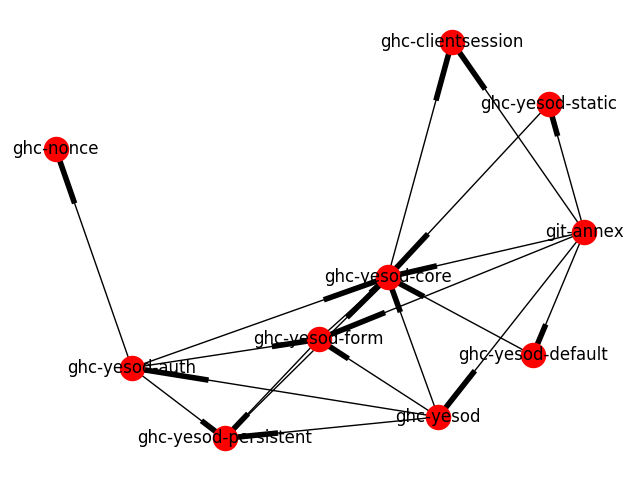

ghc-cprng-aes needs ghc-byteable, ghc-bytestring, ghc-cipher-aes, ghc-crypto-cipher-types, ghc-crypto-random, ghc-securemem, ghc-unix, ghc-vector.



/usr/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/lib64/python3.5/site-packages/matplotlib/__init__.py:920: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/lib64/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


<IPython.core.display.Javascript object>


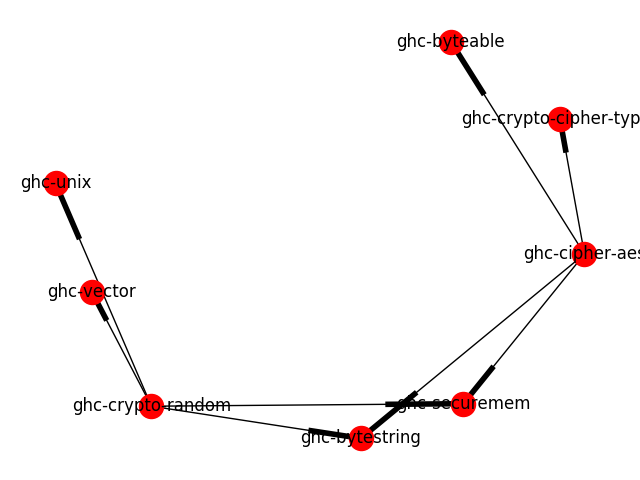

ghc-cprng-aes needs our ghc-cipher-aes, ghc-crypto-random.


<IPython.core.display.Javascript object>


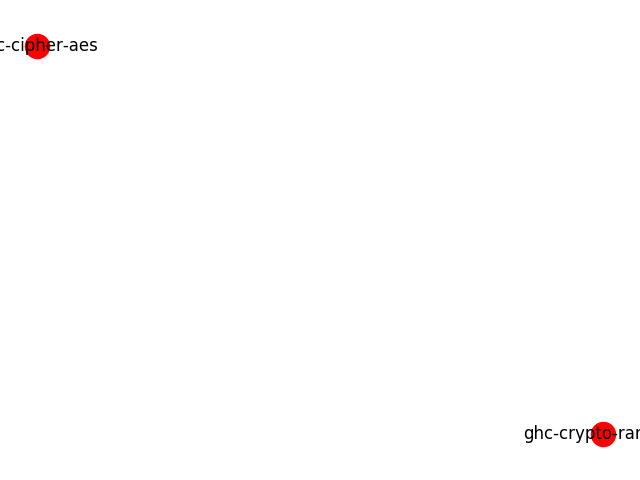

In [18]:
node = 'ghc-cprng-aes'

print(node, 'is needed by', end=' ')
print(*sorted(nx.ancestors(G, node)), sep=', ', end='.\n\n')

plt.figure()
nx.draw(G.subgraph(nx.ancestors(G, node)), with_labels=True)

print(node, 'needs', end=' ')
print(*sorted(nx.descendants(G, node)), sep=', ', end='.\n\n')

plt.figure()
nx.draw(G.subgraph(nx.descendants(G, node)), with_labels=True)

print(node, 'needs our', end=' ')
print(*sorted(nx.descendants(G, node) & our_packages), sep=', ', end='.\n')

plt.figure()
nx.draw(G.subgraph(nx.descendants(G, node) & our_packages), with_labels=True)

In [14]:
import pkgwat.api

In [15]:
for pkg in sorted(updated):
    print(pkg,
          next((row['stable_version'] for row in pkgwat.api.releases(pkg)['rows'] if row['release'] == 'Fedora 26'),
               None))

ghc-DAV None
ghc-adjunctions None
ghc-aeson-compat None
ghc-asn1-encoding None
ghc-asn1-parse None
ghc-asn1-types None
ghc-authenticate None
ghc-aws None
ghc-base-orphans None
ghc-bencode None
ghc-bifunctors None
ghc-cipher-aes None
ghc-clientsession None
ghc-comonad None
ghc-concurrent-output None
ghc-connection None
ghc-cprng-aes None
ghc-crypto-random None
ghc-cryptohash-conduit None
ghc-cryptonite None
ghc-disk-free-space None
ghc-dns None
ghc-email-validate None
ghc-esqueleto None
ghc-fdo-notify None
ghc-feed None
ghc-file-embed None
ghc-free None
ghc-hourglass None
ghc-http-api-data None
ghc-http-client None
ghc-http-client-tls None
ghc-http-conduit None
ghc-kan-extensions None
ghc-lens None
ghc-magic None
ghc-memory None
ghc-mime-mail None
ghc-mountpoints None
ghc-mtl-compat None
ghc-nats None
ghc-network-info None
ghc-network-multicast None
ghc-nonce None
ghc-pem None
ghc-persistent None
ghc-persistent-sqlite None
ghc-persistent-template None
ghc-profunctors None
ghc-resource-p